# Laboratorium 6 - rekomendacje grafowe

## Przygotowanie

 * pobierz i wypakuj dataset `movies_graph.zip`
   * dane źródłowe: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
   * więcej o przekształceniach i filtrowaniu możesz poczytać w notebooku `movies_graph_data_preparation.ipynb`
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install pykeen torch tqdm seaborn`

## Część 1. - przygotowanie danych

In [52]:
from ast import literal_eval
import csv
import numpy as np
from typing import List, Dict, Tuple
from random import shuffle

import tqdm as notebook_tqdm
import torch
from pykeen.models import ERModel, TransE
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [53]:
PATH = 'movies_graph'
TRAIN_DATA_RATIO = 0.9

In [54]:
# dataclasses


class Movie:
    def __init__(
        self,
        movie_id: str,
        title: str,
        genres: List[str],
        production_countries: List[str],
        collection_name: str,
        release_year: str,
    ):
        self.movie_id = movie_id
        self.title = title
        self.genres = genres
        self.production_countries = production_countries
        self.collection_name = collection_name
        self.release_year = release_year

    def add_cast(self, actors: List[str], directors: List[str], screenwriters: List[str], music_composers: List[str]):
        self.actors = actors
        self.directors = directors
        self.screenwriters = screenwriters
        self.music_composers = music_composers

    def basic_info(self):
        return {
            "movie_id": self.movie_id,
            "title": self.title,
            "genres": self.genres,
            "production_countries": self.production_countries,
        }

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()


class Review:
    def __init__(self, user_id: str, movie_id: str, rating: str):
        self.user_id = user_id
        self.movie_id = movie_id
        self.rating = float(rating)

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()

In [55]:
# wczytujemy oceny filmow
with open("movies_graph/reviews.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    ratings = []
    for entry in list(reader):
        user_id, movie_id, rating = entry
        ratings.append(Review(f"u_{user_id}", f"m_{movie_id}", rating))

# podzial na zbior treningowy i testowy
shuffle(ratings)
train_ratings = ratings[: int(len(ratings) * TRAIN_DATA_RATIO)]
test_ratings = ratings[len(train_ratings) :]
train_ratings

[{'user_id': 'u_211', 'movie_id': 'm_1625', 'rating': 4.0},
 {'user_id': 'u_212', 'movie_id': 'm_1608', 'rating': 3.0},
 {'user_id': 'u_19', 'movie_id': 'm_588', 'rating': 3.0},
 {'user_id': 'u_547', 'movie_id': 'm_2144', 'rating': 2.0},
 {'user_id': 'u_342', 'movie_id': 'm_906', 'rating': 4.0},
 {'user_id': 'u_654', 'movie_id': 'm_339', 'rating': 4.0},
 {'user_id': 'u_580', 'movie_id': 'm_4973', 'rating': 4.0},
 {'user_id': 'u_529', 'movie_id': 'm_2474', 'rating': 3.0},
 {'user_id': 'u_554', 'movie_id': 'm_2431', 'rating': 3.0},
 {'user_id': 'u_378', 'movie_id': 'm_54286', 'rating': 0.0},
 {'user_id': 'u_294', 'movie_id': 'm_2146', 'rating': 3.0},
 {'user_id': 'u_68', 'movie_id': 'm_934', 'rating': 3.0},
 {'user_id': 'u_217', 'movie_id': 'm_1923', 'rating': 5.0},
 {'user_id': 'u_558', 'movie_id': 'm_593', 'rating': 5.0},
 {'user_id': 'u_321', 'movie_id': 'm_2352', 'rating': 3.0},
 {'user_id': 'u_290', 'movie_id': 'm_3755', 'rating': 4.0},
 {'user_id': 'u_128', 'movie_id': 'm_3081', 'r

In [56]:
# wczytujemy metadane filmow
def parse_movie_metadata(entry: List[str]):
    movie_id, title, genres, production_countries, collection_name, release_year = entry
    return Movie(
        f"m_{movie_id}", title, literal_eval(genres), literal_eval(production_countries), collection_name, release_year
    )


def add_cast_to_movie(movie: Movie, entry: List[str]):
    _movie_id, actors, directors, screenwriters, music_composers = entry
    movie.add_cast(
        literal_eval(actors), literal_eval(directors), literal_eval(screenwriters), literal_eval(music_composers)
    )


with open("movies_graph/metadata.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    movies = {f"m_{entry[0]}": parse_movie_metadata(entry) for entry in reader}

with open("movies_graph/credits.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    for entry in reader:
        movie_id = f"m_{entry[0]}"
        add_cast_to_movie(movies[movie_id], entry)

movies

{'m_949': {'movie_id': 'm_949', 'title': 'Heat', 'genres': ['Action', 'Crime', 'Drama', 'Thriller'], 'production_countries': ['US'], 'collection_name': '', 'release_year': '1995', 'actors': ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight', 'Tom Sizemore', 'Diane Venora', 'Amy Brenneman', 'Ashley Judd', 'Mykelti Williamson', 'Natalie Portman', 'Ted Levine', 'Tom Noonan', 'Tone Loc', 'Hank Azaria', 'Wes Studi', 'Dennis Haysbert', 'Danny Trejo', 'Henry Rollins', 'William Fichtner', 'Kevin Gage', 'Susan Traylor', 'Jerry Trimble', 'Ricky Harris', 'Jeremy Piven', 'Xander Berkeley', 'Begonya Plaza', 'Rick Avery', 'Hazelle Goodman', 'Ray Buktenica', 'Max Daniels', 'Vince Deadrick Jr.', 'Steven Ford', 'Farrah Forke', 'Patricia Healy', 'Paul Herman', 'Cindy Katz', 'Brian Libby', 'Dan Martin', 'Mario Roberts', 'Thomas Rosales, Jr.', 'Yvonne Zima', 'Mick Gould', 'Bud Cort', 'Viviane Vives', 'Kim Staunton', 'Martin Ferrero', 'Brad Baldridge', 'Andrew Camuccio', 'Kenny Endoso', 'Kimberly F

## Część 2. - zbudowanie zbioru relacji

In [57]:
# generujemy dane dla modelu w formacie (head, relation, tail)
# na start mozesz uzyc malego podzbioru relacji, np. tylko 'positive_rating'

all_relation_types = [
    "positive_rating",
    "neutral_rating",
    "negative_rating",
    "genre",
    "production_country",
    "in_collection",
    "release_year",
    "actor_in",
    "director_of",
    "screenwriter_of",
    "composer_of",
]
basic_relation_types = ["positive_rating", "negative_rating"]

POSITIVE_THRESHOLD = 4.0
NEGATIVE_THRESHOLD = 2.0


def generate_triples(
    reviews: List[Review], movies: Dict[str, Movie], relation_types: List[str]
) -> List[Tuple[str, str, str]]:
    # przetlumacz dane o filmach i recenzjach do formy trojek (head, relation, tail)
    # np. (user_id, 'positive_rating', movie_id)
    # zwroc liste trzyelementowych krotek
    triples = []

    for review in reviews:
        if review.rating >= POSITIVE_THRESHOLD:
            triples.append((review.user_id, "positive_rating", review.movie_id))
        else:
            triples.append((review.user_id, "negative_rating", review.movie_id))

    return triples


triples = generate_triples(ratings, movies, basic_relation_types)
tf = TriplesFactory.from_labeled_triples(np.array(triples))

## Część 3. - trening modelu

In [58]:
def train_model(triples: List[Tuple[str, str, str]], tf: TriplesFactory, model: ERModel = TransE, epochs=100):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([0.8, 0.1, 0.1])

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # zasadnicza czesc treningu
    pipeline_result = pipeline(
        device=device,
        training=training,
        testing=testing,
        validation=validation,
        model=model,
        epochs=epochs,
    )
    return pipeline_result


pipeline_result = train_model(triples, tf)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [61698, 8029, 8029]
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/8.03k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.29s seconds


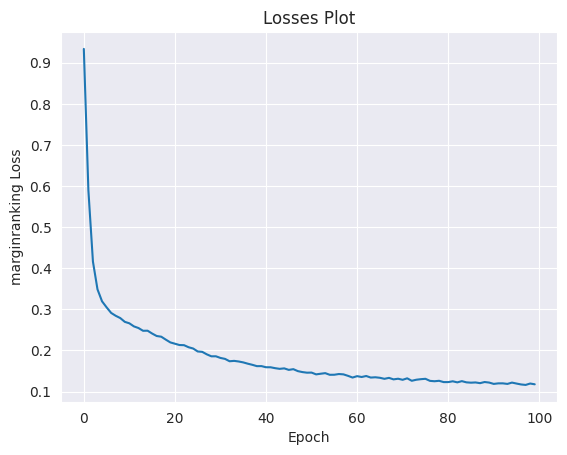

In [59]:
# wykres loss function
pipeline_result.plot_losses();

## Część 4. - rekomendacje

In [60]:
# funkcje pomocnicze
def print_movies(movie_ids: List[str], movies: Dict[str, Movie], print_missing=True):
    for m_id in movie_ids:
        if m_id in movies:
            print(movies[m_id].basic_info())
        elif print_missing:
            print(f"movie_id: {m_id}")


def describe_user(user_id: str, reviews: List[Review], movies: Dict[str, Movie]):
    positive_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating >= 4.0]
    negative_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating <= 2.0]
    neutral_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating > 2.0 and x.rating < 4.0]

    print(f"user_id: {user_id}")
    print("Positive ratings:")
    print_movies(positive_ratings, movies, print_missing=False)
    print("Neutral ratings:")
    print_movies(neutral_ratings, movies, print_missing=False)
    print("Negative ratings:")
    print_movies(negative_ratings, movies, print_missing=False)

In [61]:
def recommend(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    relation = "positive_rating"
    prediction = predict_target(model, head=user_id, relation=relation, triples_factory=triples_factory)
    # wygeneruj rekomendacje na podstawie predykcji
    df = prediction.df
    return df.loc[df["tail_label"].str.startswith("m"), "tail_label"].head(k).tolist()

In [62]:
user_id = 'u_547' # uzytkownik z bardzo duza historia
# user_id = "u_244"
describe_user(user_id, ratings, movies)
recommendation = recommend(user_id, pipeline_result.model, tf, 20)
print("Recommendation:")
print_movies(recommendation, movies)

user_id: u_547
Positive ratings:
{'movie_id': 'm_247', 'title': 'The Killing', 'genres': ['Drama', 'Action', 'Thriller', 'Crime'], 'production_countries': ['US']}
{'movie_id': 'm_594', 'title': 'The Terminal', 'genres': ['Comedy', 'Drama'], 'production_countries': ['US']}
{'movie_id': 'm_3699', 'title': 'Sette orchidee macchiate di rosso', 'genres': ['Mystery', 'Crime', 'Horror'], 'production_countries': ['DE', 'IT']}
{'movie_id': 'm_2289', 'title': 'Cold Mountain', 'genres': ['Drama'], 'production_countries': ['US', 'GB', 'RO', 'IT']}
{'movie_id': 'm_3469', 'title': 'Far from the Madding Crowd', 'genres': ['Drama', 'Romance'], 'production_countries': ['GB']}
{'movie_id': 'm_44555', 'title': '三枪拍案惊奇', 'genres': ['Comedy', 'Drama', 'Thriller'], 'production_countries': ['CN']}
{'movie_id': 'm_232', 'title': 'Rumble Fish', 'genres': ['Action', 'Adventure', 'Crime', 'Drama', 'Romance'], 'production_countries': ['US']}
{'movie_id': 'm_3418', 'title': 'La Mort en direct', 'genres': ['Drama',

## Część 5. - metryki

In [63]:
# HitRatio@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# zwracamy stosunek liczby trafien do liczby wszystkich prob

# wersja nieco bardziej zaawansowana - zamiast rekomendacji wyciagamy z modelu predykcje konkretnej relacji
# i liczymy skutecznosc w przewidywaniu, czy ocena byla pozytywna, negatywna czy neutralna


def hit_ratio(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    hits = 0
    for review in test_ratings:
        if review.rating >= POSITIVE_THRESHOLD:
            recommendation = recommend(review.user_id, model, tf, k)
            hits += review.movie_id in recommendation

    return hits / len(test_ratings)

In [64]:
# AvgPosition@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# jesli tak, zapisujemy pozycje, na ktorej zarekomendowano film
# zwracamy srednia pozycje, na ktorych wystepowaly filmy


def avg_position(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    position = 0

    for review in test_ratings:
        if review.rating >= POSITIVE_THRESHOLD:
            recommendation = recommend(review.user_id, model, tf, k)
            if review.movie_id in recommendation:
                position += recommendation.index(review.movie_id)

    return position / len(test_ratings)

In [65]:
print(f"Hit ratio   : {hit_ratio(test_ratings, pipeline_result.model, tf, 50):.3f}")
print(f"Avg position: {avg_position(test_ratings, pipeline_result.model, tf, 50):.1f}")

Hit ratio   : 0.163
Avg position: 3.4


## Część 5. - porównanie modeli

Wytrenowaliśmy podstawowy model, umiemy wygenerować rekomendacje i ocenić jakość modelu. Teraz przeanalizujemy, jakie zmiany mogą pozytywnie wpłynąć na jakość rekomendacji.

Porównaj bazowy model (np. TransH wytrenowany tylko na relacjach `positive_rating` i `negative_rating`) z dwoma innymi podejściami. Wybierz dwie spośród poniszych modyfikacji lub zaproponuj własną:
1. Zmiana modelu - zamiast TransH możesz użyć np. TransR albo RESCAL
2. Dodanie większej liczby typów relacji - możesz dodać oceny neutralne, metadane filmu, informacje o obsadzie. Nawet jeśli jakaś relacja nie jest wykorzystywana w procesie rekomendacji, może poprawić jakość wytrenowanego modelu. Zwróć uwagę, by jako rekoemndację zwracać wyłącznie identyfikatory filmów, nie innych wierzchołków.
3. Zmiana sposobu rekomendacji - obecny tryb opiera się na przewidywaniu relacji `positive_rating`. Możesz poprawić ten proces przez np. odsiewanie tych kandydatów, którzy występują także w predykcji relacji `negative_rating` czy filtrowanie kandydatów po metadanych (np. gatunku).

Porównanie trzech modeli oprzyj na dwóch zdefiniowanych w Części 4. metrykach dla wybranej wartości `k`.

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [61698, 8029, 8029]
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/251 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/8.03k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 4.05s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

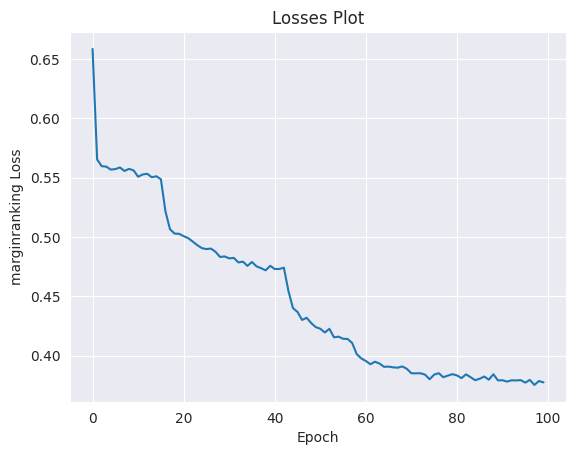

In [66]:
# Using different model
# =========================
from pykeen.models import TransR

pipeline_result = train_model(triples, tf, TransR, epochs=100)
pipeline_result.plot_losses()

In [67]:
print(f"Hit ratio   : {hit_ratio(test_ratings, pipeline_result.model, tf, 50):.3f}")
print(f"Avg position: {avg_position(test_ratings, pipeline_result.model, tf, 50):.1f}")

Hit ratio   : 0.076
Avg position: 1.8


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [65414, 10590, 10590]
INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/331 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/10.6k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 31.77s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

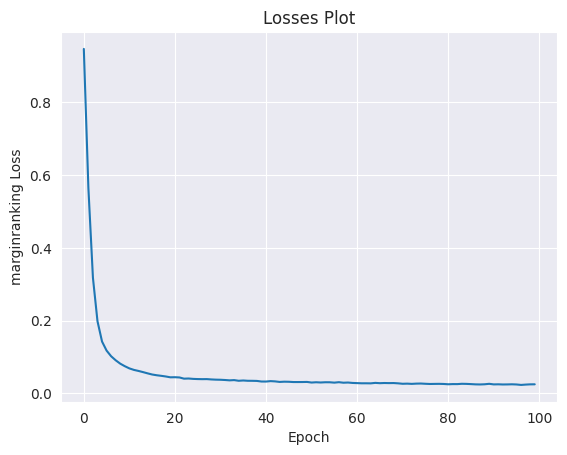

In [68]:
# Add more realtion types
# =========================

all_relation_types = [
    "positive_rating",
    "neutral_rating",
    "negative_rating",
    "genre",
    "production_country",
    "in_collection",
    "release_year",
    "actor_in",
    "director_of",
    "screenwriter_of",
    "composer_of",
]
basic_relation_types = ["positive_rating", "negative_rating"]


def generate_triples_v2(
    reviews: List[Review], movies: Dict[str, Movie], relation_types: List[str]
) -> List[Tuple[str, str, str]]:
    # przetlumacz dane o filmach i recenzjach do formy trojek (head, relation, tail)
    # np. (user_id, 'positive_rating', movie_id)
    # zwroc liste trzyelementowych krotek
    triples = []

    for review in reviews:
        if review.rating >= POSITIVE_THRESHOLD:
            triples.append((review.user_id, "positive_rating", review.movie_id))
        elif review.rating <= NEGATIVE_THRESHOLD:
            triples.append((review.user_id, "negative_rating", review.movie_id))
        else:
            triples.append((review.user_id, "neutral_rating", review.movie_id))

        if review.movie_id in movies:
            movie = movies[review.movie_id]

            for actor in movie.actors:
                triples.append((actor, "actor_in", review.movie_id))

            for genre in movie.genres:
                triples.append((review.movie_id, "genre", genre))

            for production_country in movie.production_countries:
                triples.append((review.movie_id, "production_country", production_country))

            for director in movie.directors:
                triples.append((director, "director_of", review.movie_id))

            triples.append((review.movie_id, "release_year", movie.release_year))

    return triples


triples = generate_triples_v2(ratings, movies, basic_relation_types)
tf = TriplesFactory.from_labeled_triples(np.array(triples))

pipeline_result = train_model(triples, tf, TransE, epochs=100)
pipeline_result.plot_losses()

In [69]:
print(f"Hit ratio   : {hit_ratio(test_ratings, pipeline_result.model, tf, 50):.3f}")
print(f"Avg position: {avg_position(test_ratings, pipeline_result.model, tf, 50):.1f}")

Hit ratio   : 0.110
Avg position: 2.4
